<a href="https://colab.research.google.com/github/gekoramy/uni.deep-learning/blob/standard-finetuning/standard_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Standard finetuning
In this notebook we propose the straightforward solution to fine tune CLIP. The general idea is to add linear layer(s) on top of the 1024 visual features of CLIP.

Dependences

In [139]:
%%shell
tee requirements.txt << END
ftfy
jaxtyping
jupyter
matplotlib
pydantic
regex
torch
torchvision
torchinfo
tqdm
END

pip install -q -r requirements.txt
pip install -q git+https://github.com/openai/CLIP.git
pip install -q ultralytics

ftfy
jaxtyping
jupyter
matplotlib
pydantic
regex
torch
torchvision
torchinfo
tqdm
  Preparing metadata (setup.py) ... done


In [140]:
import clip
import json
import os
import pickle
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import PIL
import itertools as it

from datetime import datetime
from jaxtyping import Float, UInt, Int
from pydantic.dataclasses import dataclass
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image
from torchinfo import summary
from typing import Literal, Callable, Mapping, TypeVar
from tqdm import tqdm
from timeit import default_timer as timer
from torch.utils.tensorboard import SummaryWriter

In [141]:
device: Literal['cpu', 'cuda'] = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
device

'cpu'

## Load the dataset
First of all we have to load the dataset.

In [142]:
%%shell
if ! [ -d dataset ]; then
  mkdir dataset &&
  gdown 1P8a1g76lDJ8cMIXjNDdboaRR5-HsVmUb &&
  tar -xf refcocog.tar.gz -C dataset &&
  rm refcocog.tar.gz
fi

Folder paths

In [143]:
root = os.path.join('dataset', 'refcocog', '')
data_instances = os.path.join(root, 'annotations', 'instances.json')
data_refs = os.path.join(root, 'annotations', 'refs(umd).p')
data_images = os.path.join(root, 'images', '')

Type declaration

In [144]:
I = TypeVar('I')
P = TypeVar('P')
B = TypeVar('B')
T = TypeVar('T')

Img = UInt[torch.Tensor, 'C W H']
BBox = UInt[torch.Tensor, '4']
Split = Literal['train', 'test', 'val']

@dataclass
class Info:
    description: str  # This is stable 1.0 version of the 2014 MS COCO dataset.
    url: str  # http://mscoco.org/
    version: str  # 1.0
    year: int  # 2014
    contributor: str  # Microsoft COCO group
    date_created: datetime  # 2015-01-27 09:11:52.357475

@dataclass
class Image:
    license: int  # each image has an associated licence id
    file_name: str  # file name of the image
    coco_url: str  # example http://mscoco.org/images/131074
    height: int
    width: int
    flickr_url: str  # example http://farm9.staticflickr.com/8308/7908210548_33e
    id: int  # id of the imag
    date_captured: datetime  # example '2013-11-21 01:03:06'

@dataclass
class License:
    url: str  # example http://creativecommons.org/licenses/by-nc-sa/2.0/
    id: int  # id of the licence
    name: str  # example 'Attribution-NonCommercial-ShareAlike License

@dataclass
class Annotation:
    #segmentation: list[list[float]]  # description of the mask; example [[44.17, 217.83, 36.21, 219.37, 33.64, 214.49, 31.08, 204.74, 36.47, 202.68, 44.17, 203.2]]
    area: float  # number of pixel of the described object
    iscrowd: Literal[1, 0]  # Crowd annotations (iscrowd=1) are used to label large groups of objects (e.g. a crowd of people)
    image_id: int  # id of the target image
    bbox: tuple[float, float, float, float]  # bounding box coordinates [xmin, ymin, width, height]
    category_id: int
    id: int  # annotation id

@dataclass
class Category:
    supercategory: str  # example 'vehicle'
    id: int  # category id
    name: str  # example 'airplane'

@dataclass
class Instances:
    info: Info
    images: list[Image]
    licenses: list[License]
    annotations: list[Annotation]
    categories: list[Category]

@dataclass
class Sentence:
    tokens: list[str]  # tokenized version of referring expression
    raw: str  # unprocessed referring expression
    sent: str  # referring expression with mild processing, lower case, spell correction, etc.
    sent_id: int  # unique referring expression id

@dataclass
class Ref:
    image_id: int  # unique image id
    split: Split
    sentences: list[Sentence]
    file_name: str  # file name of image relative to img_root
    category_id: int  # object category label
    ann_id: int  # id of object annotation in instance.json
    sent_ids: list[int]  # same ids as nested sentences[...][sent_id]
    ref_id: int  # unique id for refering expression

In [145]:
#@dataclass
#class Prediction:
#  image
#  description: list[str]  # natural language descriptions of the area of interest
#  ground_truth_bbox: tuple[float, float, float, float] # ground truth bounding box
#  output_bbox: tuple[float, float, float, float] # predicted bounding box

class Prediction:
  def __init__(self, image, description, ground_truth_bbox, output_bbox):
    self.image = image
    self.description = description
    self.ground_truth_bbox = ground_truth_bbox
    self.output_bbox = output_bbox

Read the dataset infos

In [146]:
def fix_ref(x: Ref) -> Ref:
    x.file_name = fix_filename(x.file_name)
    return x


def fix_filename(x: str) -> str:
    """
    :param x: COCO_..._[image_id]_[annotation_id].jpg
    :return:  COCO_..._[image_id].jpg
    """
    return re.sub('_\d+\.jpg$', '.jpg', x)

In [147]:
with open(data_refs, 'rb') as f:
    raw = pickle.load(f)

In [148]:
refs: list[Ref] = [
    fix_ref(Ref(**ref))
    for ref in raw
]

In [149]:
with open(data_instances, 'r') as f:
    raw = json.load(f)

In [150]:
instances: Instances = Instances(**raw)

In [151]:
id2annotation: Mapping[int, Annotation] = {
    x.id: x
    for x in instances.annotations
}

Define custom dataset

In [152]:
class CocoDataset(Dataset[tuple[I, P, B]]):

    def __init__(
        self,
        split: Split,
        img_transform: Callable[[Img], I] = lambda x: x,
        prompt_transform: Callable[[list[Sentence]], P] = lambda ps: [ p.sent for p in ps ],
        bb_transform: Callable[[Float[torch.Tensor, '4']], B] = lambda x: x
    ):
        """
        :param split: train, test or val
        :param img_transform: apply transformation on the processed images
        :param prompt_transform: apply transformation on the prompts
        :param bb_transform: apply transformation on the bounding box
        """
        self.img_transform = img_transform
        self.prompt_transform = prompt_transform
        self.bb_transform = bb_transform

        # Internally the dataset is a list of tuple[str, list[Sentence], UInt[torch.Tensor, '4']]
        # Such that:
        # str                     : image filename
        # list[Sentence]          : list of reference expression objects
        # UInt[torch.Tensor, '4'] : bounding box
        self.items: list[tuple[str, list[Sentence], Float[torch.Tensor, '4']]] = [
            (i, ps, o)
            for ref in refs
            if ref.split == split
            for i in [os.path.join(data_images, ref.file_name)]
            for ps in [ref.sentences]
            for o in [torch.tensor(id2annotation[ref.ann_id].bbox, dtype=torch.float)]
        ]


    def __len__(self) -> int:
        return len(self.items)


    def __getitem__(self, item: int) -> tuple[I, P, B]:
        i, ps, b = self.items[item]
        return (
            self.img_transform(read_image(i)),
            self.prompt_transform(ps),
            self.bb_transform(b),
        )

## Training free CLIP results
For the sake of comparison with the implementations below, we have to evaluate CLIP training free with the same portion of the dataset.

Load yolo model

In [153]:
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
yolo_model.to(device=device).eval()

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-8-15 Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

Load CLIP model

In [154]:
clip_model, preprocess = clip.load('RN50')
clip_model = clip_model.to(device=device).eval()

Baseline evaluation

In [155]:
test_dataset: Dataset[tuple[Img, list[str], UInt[torch.Tensor, '4']]] = CocoDataset(split='test')

In [156]:
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

Creating DataLoader's with batch size 1 and 2 workers.


In [157]:
MAX_ITER: int = 10 # max number of iterations
current_iteration: int = 0

stored_predictions: list[Prediction] = []

ious: list[float] = []
coss: list[float] = []
euds: list[float] = []

batch: tuple[UInt[torch.Tensor, '1 C W H'], tuple[list[tuple[str]]], UInt[torch.Tensor, '1 4']]

with torch.no_grad():
    for batch in tqdm(it.islice(iter(test_dataloader), min(MAX_ITER, len(test_dataloader))), total=min(MAX_ITER, len(test_dataloader))):
        [img], (prompts), [true_xywh] = batch

        [true_xyxy] = torchvision.ops.box_convert(true_xywh.unsqueeze(0), in_fmt='xywh', out_fmt='xyxy')

        img_pil: Image = transforms.ToPILImage()(img)

        # yolo bboxes
        predictions = yolo_model(img_pil)

        # xmin,      ymin,      xmax,      ymax,      confidence, class
        # 274.06390, 231.20389, 392.66345, 372.59018, 0.93251,    23.00000
        bboxes: Float[torch.Tensor, 'X 6'] = predictions.xyxy[0]

        # if empty, put a bbox equal to image size
        if len(bboxes) == 0:
            bboxes = torch.tensor([[0, 0, img.size()[1], img.size()[2], 0, 0]], dtype=torch.float)

        # from yolo bboxes to cropped images
        crops: list[Image] = [
            img_pil.crop((xmin, ymin, xmax, ymax))
            for bbox in bboxes
            for [xmin, ymin, xmax, ymax, _, _] in [bbox.tolist()]
        ]

        # clip preprocess on cropped images
        preprocess_crops: Float[torch.Tensor, 'X 3 244 244'] = torch.stack([
            preprocess(crop)
            for crop in crops
        ]).to(device=device)

        # format each available prompt
        prompts_tokens: Int[torch.Tensor, 'P 77'] = clip.tokenize([
            template.format(prompt)
            for template in ["{}", "A photo of {}", "We can see {}"]
            for (prompt,) in prompts  # <- ¯\_(ツ)_/¯
        ])

        # clip scores
        ass_z: tuple[Float[torch.Tensor, 'X P'], Float[torch.Tensor, 'P X']] = clip_model(preprocess_crops, prompts_tokens)
        _, logits_per_prompt = ass_z

        # final prediction
        best_match: int = torch.argmax(torch.max(logits_per_prompt, 0).values).item()
        prediction_bbox: Float[torch.Tensor, '4'] = bboxes[best_match][:4]

        # metrics
        iou: float = torchvision.ops.box_iou(true_xyxy.unsqueeze(0), prediction_bbox.unsqueeze(0)).item()
        ious.append(iou)

        rectangle: tuple[int, int, int, int] = true_xyxy.tolist()
        ground_truth_crop = img_pil.crop(rectangle)

        rectangle: tuple[int, int, int, int] = torch.tensor(prediction_bbox, dtype=torch.int).tolist()
        prediction_crop = img_pil.crop(rectangle)

        # from float16 to float32
        X: Float[torch.Tensor, '1'] = torch.tensor(
            clip_model.encode_image(torch.tensor(preprocess(ground_truth_crop)).unsqueeze(0)),
            dtype=torch.float
        )
        Y: Float[torch.Tensor, '1'] = torch.tensor(
            clip_model.encode_image(torch.tensor(preprocess(prediction_crop)).unsqueeze(0)),
            dtype=torch.float
        )

        cos: float = F.cosine_similarity(X, Y).item()
        coss.append(cos)

        eud: float = torch.cdist(X, Y, p=2).item()
        euds.append(eud)

        # store the prediction
        pred : Prediction = Prediction(
              image = img,
              description = [p[0] for p in prompts],
              ground_truth_bbox = true_xyxy,
              output_bbox = prediction_bbox
            )
        stored_predictions.append(pred)

        torch.cuda.empty_cache()

100%|██████████| 10/10 [00:32<00:00,  3.23s/it]


In [158]:
prompts_tokens.shape

torch.Size([6, 77])

In [159]:
preprocess_crops.shape

torch.Size([1, 3, 224, 224])

In [160]:
len(stored_predictions)

10

Performance:

In [161]:
print(f"ious: {torch.mean(torch.tensor(ious, dtype=torch.float))}")
print(f"coss: {torch.mean(torch.tensor(coss, dtype=torch.float))}")
print(f"euds: {torch.mean(torch.tensor(euds, dtype=torch.float))}")

ious: 0.8920486569404602
coss: 0.9736908078193665
euds: 0.46590811014175415


Function to display a random sample of predictions.

In [162]:
# args:
#  - predictionList: [Prediction]
#  - numPred: int :: if numPred==-1 (default) consider all the predictions in predictionList
def display_predictions(predictionList, numPred=-1):
  limit = 0
  for p in predictionList:
    if numPred!=-1 and limit >= numPred:
      return;
    limit += 1

    p_image = p.image
    p_description = p.description
    p_ground_truth_bbox = p.ground_truth_bbox
    p_output_bbox = p.output_bbox

    # TODO: concatenate
    p_image = draw_bounding_boxes(p_image, p_ground_truth_bbox.unsqueeze(0), colors="green", width=5)
    p_image = draw_bounding_boxes(p_image, p_output_bbox.unsqueeze(0), colors="red", width=5)

    tensor_to_pil = transforms.ToPILImage()
    image_pil = tensor_to_pil(p_image)
    display(image_pil)
    print(p_description)
    print("\n\n")

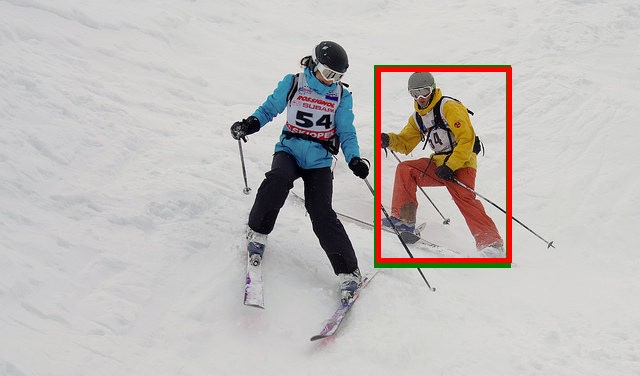

['the man in yellow coat', 'skiier in red pants']





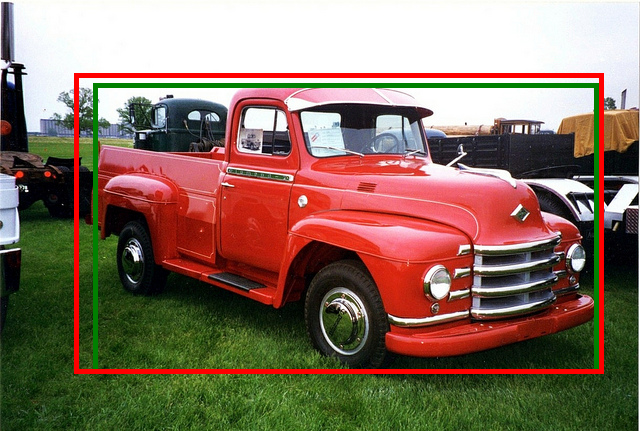

['there is red colored truck in between the other trucks', 'a shiny red vintage pickup truck']





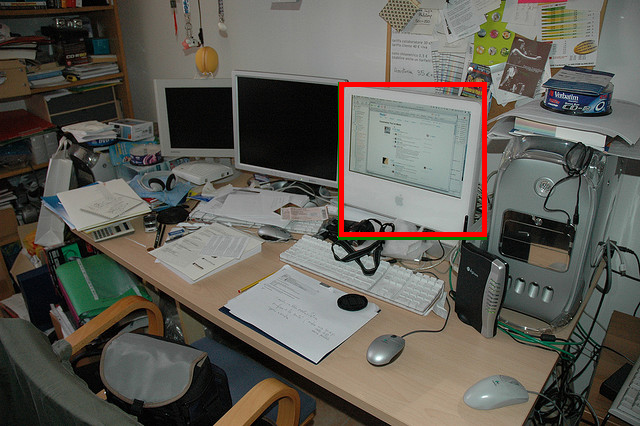

['a apple desktop computer', 'the white imac computer that is also turned on']





In [163]:
display_predictions(stored_predictions, 3)

## Region proposal networks

### YOLOv5

In [164]:
class Yolo_v5(torch.nn.Module):
  def __init__(self, device=device):
    super().__init__()

    # load yolo model
    yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
    yolo_model.to(device=device).eval()

  def forward(self, img: torch.Tensor) -> torch.Tensor: # TODO: img non credo che sia di tipo torch.Tensor
    # convert image tensor to image PIL
    pil_transormation = transforms.ToPILImage()
    img_pil = [pil_transormation(_img) for _img in img]

    #######print(f"img_pil 0: {type(img_pil)}")
    #######print(f"img_pil 1: {len(img_pil)}")

    # yolo bboxes
    predictions = yolo_model(img_pil)
    #######print(f"predictions type: {type(predictions)}")
    #######predictions.show()

    #######print("predictions.xyxy")
    #######print(predictions.xyxy)
    #######print("predictions.xyxy len")
    #######print(len(predictions.xyxy))

    # xmin,      ymin,      xmax,      ymax,      confidence, class
    # 274.06390, 231.20389, 392.66345, 372.59018, 0.93251,    23.00000
    bboxes: list[Float[torch.Tensor, 'X 6']] = predictions.xyxy # bboxes[i] contains the bboxes highlighted by yolo in image i

    #######print("len bboxes")
    #######print(len(bboxes))

    for image_idx, bbox_img in enumerate(bboxes):
      # if empty, put a bbox equal to image size
      if len(bbox_img) == 0:
          bbox_img = torch.tensor([[0, 0, img_pil[image_idx].size()[1], img_pil[image_idx].size()[2], 0, 0]], dtype=torch.float)  # TODO: test this piece of code

    return bboxes

## Linear layers on top of image encoder

In [165]:
summary(clip_model)

Layer (type:depth-idx)                                            Param #
CLIP                                                              563,713
├─ModifiedResNet: 1-1                                             --
│    └─Conv2d: 2-1                                                864
│    └─BatchNorm2d: 2-2                                           64
│    └─ReLU: 2-3                                                  --
│    └─Conv2d: 2-4                                                9,216
│    └─BatchNorm2d: 2-5                                           64
│    └─ReLU: 2-6                                                  --
│    └─Conv2d: 2-7                                                18,432
│    └─BatchNorm2d: 2-8                                           128
│    └─ReLU: 2-9                                                  --
│    └─AvgPool2d: 2-10                                            --
│    └─Sequential: 2-11                                           --
│    │    └─Bot

In [166]:
#summary(clip_model.visual, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"])

In [167]:
summary(clip_model.transformer, input_size=(77,512), col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
Transformer                              [77, 512]                 [77, 512]                 --                        True
├─Sequential: 1-1                        [77, 512]                 [77, 512]                 --                        True
│    └─ResidualAttentionBlock: 2-1       [77, 512]                 [77, 512]                 --                        True
│    │    └─LayerNorm: 3-1               [77, 512]                 [77, 512]                 1,024                     True
│    │    └─MultiheadAttention: 3-2      [77, 512]                 [77, 512]                 1,050,624                 True
│    │    └─LayerNorm: 3-3               [77, 512]                 [77, 512]                 1,024                     True
│    │    └─Sequential: 3-4              [77, 512]                 [77, 512]                 2,099,712                 True
│  

In the following cell we create a neural network that builds a linear head on top of the visual encoder of CLIP.

In [168]:
class CLIP_SF_image_encoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    model, _ = clip.load("RN50")

    # take the visual encoder of CLIP
    # we also convert it to be 32 bit (by default CLIP is 16)
    self.encoder = model.visual

    # freeze all pretrained layers by setting requires_grad=False
    for param in self.encoder.parameters():
      param.requires_grad = False

    # add a linear layer
    self.fc1 = nn.Linear(1024, 1024)
    self.fc2 = nn.Linear(1024, 1024)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # visual encoder
    with torch.no_grad():
      x = self.encoder(x)
    # ---

    # linear head
    x = self.fc1(x)
    x = F.relu(x)

    x = self.fc2(x)
    # ---

    return x

In [169]:
class CLIP_SF_text_encoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    model, _ = clip.load("RN50")

    # take the text encoder of CLIP
    self.encoder = model.transformer

    # freeze all pretrained layers by setting requires_grad=False
    for param in self.encoder.parameters():
      param.requires_grad = False

    # add a linear layer
    self.fc1 = nn.Linear(1024, 1024)
    self.fc2 = nn.Linear(1024, 1024)

  def forward(self, x):
    # visual encoder
    with torch.no_grad():
      x = self.encoder(x)
    # ---

    # linear head
    x = self.fc1(x)
    x = F.relu(x)

    x = self.fc2(x)
    # ---

    return x

In [170]:
net = CLIP_SF_image_encoder().to(device)
summary(net, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Trainable
CLIP_SF_image_encoder                         [1, 3, 224, 224]          [1, 1024]                 --                        Partial
├─ModifiedResNet: 1-1                         [1, 3, 224, 224]          [1, 1024]                 --                        False
│    └─Conv2d: 2-1                            [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    └─BatchNorm2d: 2-2                       [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    └─ReLU: 2-3                              [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─Conv2d: 2-4                            [1, 32, 112, 112]         [1, 32, 112, 112]         (9,216)                   False
│    └─BatchNorm2d: 2-5                       [1, 32, 112, 112]         [1, 32, 112, 11

In [171]:
class CLIP_SF(torch.nn.Module):
  def __init__(self,
               visual_encoder,                      # visual encoder
               visual_encoder_preprocess,           # visual encoder preprocessing
               text_encoder,                        # natural language prompts encoder
               text_encoder_preprocess,             # text encoder preprocessing
               freeze_visual_encoder : bool = True, # TRUE -> visual encoder parameters are not trained
               freeze_text_encoder : bool = False   # TRUE -> text encoder parameters are not trained
               ):
    super().__init__()

    self.visual_encoder = visual_encoder
    self.text_encoder = text_encoder
    self.visual_encoder_preprocess = visual_encoder_preprocess
    self.text_encoder_preprocess = text_encoder_preprocess
    self.freeze_visual_encoder = freeze_visual_encoder
    self.freeze_text_encoder = freeze_text_encoder

    """
    if freeze_visual_encoder:
      for param in self.visual_encoder.parameters():  # freeze all pretrained layers by setting requires_grad=False
        param.requires_grad = False

    if freeze_text_encoder:
      for param in self.text_encoder.parameters():    # freeze all pretrained layers by setting requires_grad=False
        param.requires_grad = False
    """

  # preprocess input prompts as required by the visual encoder
  def visual_preprocess(self, input_crops):
    output_crops: Float[torch.Tensor, 'X 3 244 244'] = torch.stack([
        self.visual_encoder_preprocess(crop)
        for crop in input_crops
    ]).to(device=device)

    return output_crops

  # preprocess text prompts as required by the text encoder
  def text_preprocess(self, input_prompts):
    print("input_prompts")
    print(input_prompts)
    output_prompts: Int[torch.Tensor, 'P 77'] = self.text_encoder_preprocess([
        prompt
        for prompt in input_prompts
    ])

    print("concluded text_preprocess")

    return output_prompts

  def cosine_similarity(self, images_z: torch.Tensor, texts_z: torch.Tensor):
    # normalise the image and the text
    images_z /= images_z.norm(dim=-1, keepdim=True)
    texts_z /= texts_z.norm(dim=-1, keepdim=True)

    # evaluate the cosine similarity between the sets of features
    similarity = (texts_z @ images_z.T)

    return similarity.cpu()

  def forward(self, x):
    # x :: [([crop11, crop12, ..., crop1M], [prompt_11, ..., prompt_1N]), ([crop21, crop22, ..., crop2P], [prompt_21, ..., prompt_2K])]

    print("OMG forward start!")

    y = list()

    for input_x in x:
      # input_x :: ([crop11, crop12, ..., crop1M], [prompt_11, ..., prompt_1N])

      prediction_bbox_index = -1

      input_x_crop_list = input_x[0]
      input_x_prompt_list = input_x[1]

      print(len(input_x_crop_list))
      print(input_x_prompt_list)

      # step 1: preprocess crops as required by the visual encoder
      with torch.no_grad():
        input_x_crop_list_preprocessed = self.visual_preprocess(input_x_crop_list)

      # step 2: preprocess prompts as required by the text encoder
      with torch.no_grad():
        input_x_prompt_list_preprocessed = self.text_preprocess(input_x_prompt_list)

      print("input_x_crop_list_preprocessed.shape")
      print(input_x_crop_list_preprocessed.shape)
      print("input_x_prompt_list_preprocessed.shape")
      print(input_x_prompt_list_preprocessed.shape)

      # step 3: compute crop representation in the latent space
      if self.freeze_visual_encoder:
        with torch.no_grad():
          crop_list_z = self.visual_encoder(input_x_crop_list_preprocessed)
      else:
        crop_list_z = self.visual_encoder(input_x_crop_list_preprocessed)

      print()
      print("crop_list_z")
      print(type(crop_list_z))
      print(crop_list_z.shape)

      # step 4: compute prompt representation in the latent space
      if self.freeze_text_encoder:
        with torch.no_grad():
          prompt_list_z = self.text_encoder(input_x_prompt_list_preprocessed)
      else:
          prompt_list_z = self.text_encoder(input_x_prompt_list_preprocessed)

      print()
      print("prompt_list_z")
      print(type(prompt_list_z))
      print(prompt_list_z.shape)

      # step 5: evaluate logits
      similarity_matrix = self.cosine_similarity(crop_list_z, prompt_list_z)

      print("\nSIMILARITY MATRIX")
      print(similarity_matrix)
      print()

      # step 6: get prediction
      mean_similarity_bbox = torch.mean(similarity_matrix, dim=1)

      print("mean_similarity_bbox")
      print(mean_similarity_bbox)

      prediction_bbox_index = torch.argmax(torch.mean(similarity_matrix, dim=1))

      print("prediction_bbox_index")
      print(prediction_bbox_index)

      y.append(prediction_bbox_index.item())


    return torch.tensor(y, dtype=torch.float32)

In [172]:
def get_optimizer(model, _lr, _wd, _momentum):
  optimizer = torch.optim.SGD(  params = model.parameters(),
                                lr = _lr,
                                weight_decay = _wd,
                                momentum = _momentum)

  return optimizer

In [173]:
def get_cost_function():
  def iou_loss(bbox_prediction, bbox_groundtruth):
    return -1*torchvision.ops.box_iou(bbox_groundtruth, bbox_prediction).item()

  return iou_loss

In [174]:
def get_accuracy_function():
  def iou_accuracy(bbox_prediction, bbox_groundtruth):
    return torchvision.ops.box_iou(bbox_groundtruth, bbox_prediction).item()
  return iou_accuracy

In [175]:
# deal with different size tensors in dataloader
def custom_collate(batch) -> tuple[list[Img], list[str], list[Float[torch.Tensor, '4']]]:
    images = [item[0] for item in batch]
    prompts = [item[1] for item in batch]
    bboxes = [item[2] for item in batch]

    return images, prompts, bboxes

In [193]:
def training_step(
    model: torch.nn.Module,                     # neural network to be trained
    region_proposal_model: torch.nn.Module,     # region proposal model
    data_loader: torch.utils.data.DataLoader,   # [train_dataset]
    loss_fn: torch.nn.Module,                   # todo: in our case it is not correct nn.Module, test data type
    optimizer: torch.optim.Optimizer,           # optimizer
    accuracy_fn,                                # accuracy function
    max_sample: int = -1,                       # useful during the experiments to set an upper bound on the number of samples to be evaluated (-1 :: no limit)
    device: torch.device = device               # target device
    ):

  print("training_step")
  train_loss = 0.0
  train_acc = 0.0 #todo riflettere anche su questo

  model.to(device)
  model.train()

  num_iteration: int = 0  # keep track of the number of iterations
  for batch_idx, (img, prompts, true_xywh) in tqdm(it.islice(enumerate(data_loader), (len(data_loader) if max_sample == -1 else max_sample))):


    print()
    print(f"batch_idx: {batch_idx}")
    print(f"img: {img}")
    print(f"type img: {type(img)}")
    print(f"prompts: {prompts}")
    print(f"true_xywh: {true_xywh}")

    # check number of iteration
    if max_sample!=-1 and num_iteration>=max_sample:
      print("\n STOP TRAINING LOOP FOR MAX ITERATION PARAMETER \n")
      break
    num_iteration+=1

    # send data to target device
    for _img in img:
      _img = _img.to(device)

    true_xywh = torch.stack((true_xywh)).to(device)

    print(f"true_xywh new: {true_xywh}")
    print(f"true_xywh new shape: {true_xywh.shape}")

    # convert bbox to the proper format
    [true_xyxy] = torchvision.ops.box_convert(true_xywh.unsqueeze(0), in_fmt='xywh', out_fmt='xyxy')

    print("len: ")
    print(len(true_xyxy))
    print(true_xyxy)

    # forward pass

    with torch.no_grad():
      # i. region proposal
      bboxes = region_proposal_model(img)

      print(f"\n\n REGION PROPOSAL ALGORITHM DONE bounding boxes: {bboxes}\n\n")

      """
      # from yolo bboxes to cropped images
      crops: list[Image] = [
          img_pil.crop((xmin, ymin, xmax, ymax))
          for bbox in bboxes
          for [xmin, ymin, xmax, ymax, _, _] in [bbox.tolist()]
      ]
      """

      # from yolo bboxes to cropped images
      crops = []
      for batch_image, batch_image_bboxes in zip(img, bboxes):
        print(f"batch_image: {batch_image.shape}")
        print(f"batch_image_bboxes: {batch_image_bboxes}")
        batch_image_pil: Image = transforms.ToPILImage()(batch_image)

        list_bboxes_image: list[Image] = [
            batch_image_pil.crop((xmin, ymin, xmax, ymax))
            for bbox in batch_image_bboxes
            for [xmin, ymin, xmax, ymax, _, _] in [bbox.tolist()]
        ]

        crops.append(list_bboxes_image)

      print(len(crops))
      print(crops[0])
      print(crops[1])

      model_input = list(zip(crops, prompts))

      print("model_input")
      print(len(model_input))
      print(len(model_input[0][0]))
      print(len(model_input[1][1]))

      model_output = net(model_input)

      print("\n\nMODEL OUTPUT FINALLY (-:")
      print(model_output)

      print("\noutput size")
      print(crops[0][int(model_output[0])])
      print()
      xywh = torchvision.ops.box_convert(bboxes[0][int(model_output[0]),:4].unsqueeze(0), in_fmt='xyxy', out_fmt='xywh')
      print("prima dell'output")
      print(f"xywh = {xywh}")

      """

      # ii. CLIP preprocessing  # todo: riflettere se mettere il preprocessing di CLIP nel nn.Module
      # clip preprocess on cropped images
      preproceessed_crops_batch = list()
      for image_crops in crops:
        preprocess_crops: Float[torch.Tensor, 'X 3 244 244'] = torch.stack([
            preprocess(crop)
            for crop in image_crops
        ]).to(device=device)
        preproceessed_crops_batch.append(preprocess_crops)


      # format each available prompt
      prompts_tokens = list()
      for batch_item_prompt in prompts:

        print("!!!!batch_item_prompt!!!")
        print(batch_item_prompt)

        batch_item_prompt_tokens: Int[torch.Tensor, 'P 77'] = clip.tokenize([
            template.format(prompt)
            for template in ["{}", "A photo of {}", "We can see {}"]
            for prompt in batch_item_prompt  # <- ¯\_(ツ)_/¯
        ])
        prompts_tokens.append(batch_item_prompt_tokens)

      print("\prompts_tokens")
      print(len(prompts_tokens))
      print(prompts_tokens[0].shape)
      print(prompts_tokens[1].shape)

    # iii. process visual prompts
    model_encoding = model(preproceess_crops_batch)

    print("model_encoding")
    print(model_encoding)

    # iv. evaluate similarity bbox - prompt

    # v. final prediction

    # loss and accuracy computation

    # optimizer zero grad

    # loss backward

    # optimizer step

    ass_z: tuple[Float[torch.Tensor, 'X P'], Float[torch.Tensor, 'P X']] = clip_model(preprocess_crops, prompts_tokens)
    _, logits_per_prompt = ass_z

    # final prediction
    best_match: int = torch.argmax(torch.max(logits_per_prompt, 0).values).item()
    prediction_bbox: Float[torch.Tensor, '4'] = bboxes[best_match][:4]

    # metrics
    iou: float = torchvision.ops.box_iou(true_xyxy.unsqueeze(0), prediction_bbox.unsqueeze(0)).item()
    ious.append(iou)

    rectangle: tuple[int, int, int, int] = true_xyxy.tolist()
    ground_truth_crop = img_pil.crop(rectangle)

    rectangle: tuple[int, int, int, int] = torch.tensor(prediction_bbox, dtype=torch.int).tolist()
    prediction_crop = img_pil.crop(rectangle)

    # from float16 to float32
    X: Float[torch.Tensor, '1'] = torch.tensor(
        clip_model.encode_image(torch.tensor(preprocess(ground_truth_crop)).unsqueeze(0)),
        dtype=torch.float
    )
    Y: Float[torch.Tensor, '1'] = torch.tensor(
        clip_model.encode_image(torch.tensor(preprocess(prediction_crop)).unsqueeze(0)),
        dtype=torch.float
    )

    cos: float = F.cosine_similarity(X, Y).item()
    coss.append(cos)

    eud: float = torch.cdist(X, Y, p=2).item()
    euds.append(eud)
"""
  # Calculate loss (todo: and accuracy) per epoch and print out what's happening
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.5f}")
  return test_loss, train_acc

In [177]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval() # put model in eval mode

  # Turn on inference context manager
  with torch.inference_mode():
      for X, y in data_loader:
          # Send data to GPU
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred = model(X)

          # 2. Calculate loss and accuracy
          test_loss += loss_fn(test_pred, y)
          test_acc += accuracy_fn(y_true=y,
              y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
          )

      # Adjust metrics and print out
      test_loss /= len(data_loader)
      test_acc /= len(data_loader)
      print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
      return test_loss, test_acc

Put all together in a training loop.

In [178]:
# tensorboard logging utilities
def log_values(writer, step, loss, accuracy, prefix):
  writer.add_scalar(f"{prefix}/loss", loss, step)
  writer.add_scalar(f"{prefix}/accuracy", accuracy, step)

In [179]:
# load clip model and retrieve textual and visual encoders
clip_model, preprocess = clip.load('RN50')
clip_model = clip_model.to(device=device).eval()
#clip_visual_encoder = clip_model.visual
#clip_visual_encoder = clip_visual_encoder.to(device=device).eval()
clip_visual_encoder = clip_model.encode_image
#clip_text_encoder = clip_model.transformer
#clip_text_encoder = clip_text_encoder.to(device=device).eval()
clip_text_encoder = clip_model.encode_text

In [180]:
# personalized visual encoder
sf_visual_encoder = CLIP_SF_image_encoder().to(device)

In [181]:
# personalized text encoder
sf_text_encoder = CLIP_SF_text_encoder().to(device)

In [182]:
# flag configuration to decide the encoders to be trained
freeze_visual_encoder = True
freeze_text_encoder = True

# instantiate the network and move it to the chosen device (GPU)
net = CLIP_SF(  visual_encoder = sf_visual_encoder,
                visual_encoder_preprocess = preprocess,
                text_encoder = clip_text_encoder,
                text_encoder_preprocess = clip.tokenize,
                freeze_visual_encoder = freeze_visual_encoder,
                freeze_text_encoder = freeze_text_encoder).to(device)

In [183]:
# instantiate the region proposal algorithm
yolo = Yolo_v5().to(device)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-8-15 Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [194]:
# setting a manual seed allow us to provide reprudicible results in this notebook
torch.manual_seed(42)

# measure time
train_time_start = timer()  # todo: forse misurando il tempo possiamo far apprezzare la differenza di tempo di esecuzione del training quando abbiamo fatto il preprocessing delle bounding box vs senza

# create a logger for the experiment
writer = SummaryWriter(log_dir="runs/exp1")

# get dataset instance
train_dataset: Dataset[tuple[Img, list[str], UInt[torch.Tensor, '4']]] = CocoDataset(split='train')
test_dataset: Dataset[tuple[Img, list[str], UInt[torch.Tensor, '4']]] = CocoDataset(split='test')
val_dataset: Dataset[tuple[Img, list[str], UInt[torch.Tensor, '4']]] = CocoDataset(split='val')
print(f"LEN_TRAIN_DATASET: {len(train_dataset)}, LEN_TEST_DATASET: {len(test_dataset)}, LEN_VALIDATION_DATASET: {len(val_dataset)}")

# get dataloaders
BATCH_SIZE = 2
#NUM_WORKERS = os.cpu_count()
NUM_WORKERS = 1
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    collate_fn=custom_collate,
    shuffle=True
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)
print(f"LEN_TRAIN_DATALOADER: {len(train_loader)}, LEN_TEST_DATALOADER: {len(val_loader)}, LEN_VALIDATION_DATALOADER: {len(test_loader)}")

# instantiate the optimizer
learning_rate = 0.01
weight_decay = 0.000001
momentum = 0.9
optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

# define the cost function
cost_function = get_cost_function()

# define the accuracy function
accuracy_fn = get_accuracy_function()

# computes evaluation results before training
print('Before training:')
#train_loss, train_accuracy = test_step(net, train_loader, cost_function)
#val_loss, val_accuracy = test_step(net, val_loader, cost_function)
#test_loss, test_accuracy = test_step(net, test_loader, cost_function)

# log to TensorBoard
#log_values(writer, -1, train_loss, train_accuracy, "train")
#log_values(writer, -1, val_loss, val_accuracy, "validation")
#log_values(writer, -1, test_loss, test_accuracy, "test")

#print('\tTraining loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
#print('\tValidation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
#print('\tTest loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
print('-----------------------------------------------------')

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_loss, train_accuracy = training_step(
        model = net,
        region_proposal_model = yolo,
        data_loader = train_loader,
        loss_fn = cost_function,
        optimizer = optimizer,
        accuracy_fn = accuracy_fn,
        max_sample = 5
    )
    val_loss, val_accuracy = test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

    # logs to TensorBoard
    log_values(writer, e, val_loss, val_accuracy, "Validation")

    print('Epoch: {:d}'.format(e+1))
    print('\tTraining loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\tValidation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)
# compute final evaluation results
print('After training:')
train_loss, train_accuracy = test_step(net, train_loader, cost_function)
val_loss, val_accuracy = test_step(net, val_loader, cost_function)
test_loss, test_accuracy = test_step(net, test_loader, cost_function)

# log to TensorBoard
log_values(writer, epochs, train_loss, train_accuracy, "train")
log_values(writer, epochs, val_loss, val_accuracy, "validation")
log_values(writer, epochs, test_loss, test_accuracy, "test")

print('\tTraining loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
print('\tValidation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
print('\tTest loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
print('-----------------------------------------------------')

# closes the logger
writer.close()

LEN_TRAIN_DATASET: 42226, LEN_TEST_DATASET: 5023, LEN_VALIDATION_DATASET: 2573
Creating DataLoader's with batch size 2 and 1 workers.
LEN_TRAIN_DATALOADER: 21113, LEN_TEST_DATALOADER: 1287, LEN_VALIDATION_DATALOADER: 2512
Before training:
-----------------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
training_step



0it [00:00, ?it/s]


batch_idx: 0
img: [tensor([[[ 37,  39,  28,  ...,  31,  28,  24],
         [ 21,  29,  25,  ...,  29,  38,  42],
         [127, 139, 146,  ...,  21,  40,  30],
         ...,
         [166, 183, 147,  ..., 223, 226, 247],
         [214, 115,  61,  ..., 221, 204, 190],
         [130, 148, 255,  ..., 220, 249,  73]],

        [[ 70,  59,  41,  ...,  41,  36,  27],
         [ 44,  48,  42,  ...,  39,  46,  45],
         [134, 151, 162,  ...,  30,  46,  34],
         ...,
         [180, 190, 156,  ..., 232, 236, 255],
         [225, 124,  65,  ..., 230, 214, 204],
         [136, 157, 255,  ..., 230, 255,  87]],

        [[ 39,  66,  47,  ...,  14,  15,  18],
         [ 34,  42,  23,  ...,  12,  23,  28],
         [162, 151, 135,  ...,   3,  18,   9],
         ...,
         [105, 146,  89,  ..., 227, 228, 240],
         [157,  69,  14,  ..., 225, 205, 181],
         [ 76,  90, 228,  ..., 222, 248,  62]]], dtype=torch.uint8), tensor([[[ 33,  31,  31,  ...,  70,  68,  67],
         [ 36,  35,


1it [00:04,  4.82s/it]


prompt_list_z
<class 'torch.Tensor'>
torch.Size([2, 1024])

SIMILARITY MATRIX
tensor([[ 1.76674e-02,  1.23378e-02,  8.53731e-03,  8.72866e-03,  8.56456e-03,  2.07682e-02,  1.18453e-02,  2.60793e-02,  2.51198e-02, -1.22652e-02],
        [ 1.86625e-03,  2.70624e-05, -5.79719e-03, -5.44166e-03, -7.85233e-03,  2.06119e-03, -1.51406e-03,  1.58068e-02,  1.23372e-02, -2.88368e-02]])

mean_similarity_bbox
tensor([ 0.01274, -0.00173])
prediction_bbox_index
tensor(0)


MODEL OUTPUT FINALLY (-:
tensor([1., 0.])

output size
<PIL.Image.Image image mode=RGB size=53x214 at 0x7E1834B53160>

prima dell'output
xywh = tensor([[452.63312,  88.27678,  53.38708, 214.06252]])

batch_idx: 1
img: [tensor([[[ 2,  9, 13,  ..., 24, 16, 31],
         [16, 14, 14,  ..., 23, 17, 16],
         [27, 18, 14,  ..., 17, 19, 10],
         ...,
         [55, 54, 68,  ..., 59, 56, 49],
         [53, 43, 58,  ..., 62, 57, 45],
         [42, 57, 60,  ..., 50, 52, 46]],

        [[ 6, 11, 13,  ..., 16,  7, 22],
         [16,


2it [00:11,  5.95s/it]


prompt_list_z
<class 'torch.Tensor'>
torch.Size([2, 1024])

SIMILARITY MATRIX
tensor([[-0.00511,  0.00547,  0.02088, -0.00928, -0.01890,  0.01187,  0.01508,  0.00676,  0.00351,  0.03292,  0.00468,  0.01802,  0.01510,  0.00689],
        [ 0.01721,  0.01588,  0.04258,  0.00699,  0.01055,  0.02449,  0.02525,  0.01685,  0.02195,  0.05052,  0.01600,  0.03411,  0.04372,  0.02757]])

mean_similarity_bbox
tensor([0.00771, 0.02526])
prediction_bbox_index
tensor(1)


MODEL OUTPUT FINALLY (-:
tensor([0., 1.])

output size
<PIL.Image.Image image mode=RGB size=562x465 at 0x7E1834BA04F0>

prima dell'output
xywh = tensor([[ 67.18204,   0.00000, 562.11877, 464.85358]])

batch_idx: 2
img: [tensor([[[119, 119, 120,  ...,  20,  13,   8],
         [119, 120, 120,  ...,  18,  11,   6],
         [118, 120, 121,  ...,  16,   9,   5],
         ...,
         [ 55,  43,  51,  ...,  90,  52,  47],
         [ 96, 106,  94,  ..., 104,  76,  44],
         [ 90,  89,  96,  ..., 102,  79,  58]],

        [[ 77,  77,


3it [00:17,  5.83s/it]


prompt_list_z
<class 'torch.Tensor'>
torch.Size([2, 1024])

SIMILARITY MATRIX
tensor([[ 0.01677,  0.03092,  0.01750,  0.01817,  0.00295,  0.02576],
        [-0.01606, -0.00502, -0.01344, -0.02766, -0.02759, -0.01283]])

mean_similarity_bbox
tensor([ 0.01868, -0.01710])
prediction_bbox_index
tensor(0)


MODEL OUTPUT FINALLY (-:
tensor([0., 0.])

output size
<PIL.Image.Image image mode=RGB size=142x177 at 0x7E1834B53160>

prima dell'output
xywh = tensor([[498.09738,   5.63420, 141.90262, 177.07965]])

batch_idx: 3
img: [tensor([[[175, 172, 172,  ..., 170, 175, 173],
         [165, 175, 177,  ..., 171, 178, 177],
         [169, 167, 165,  ..., 171, 173, 173],
         ...,
         [160, 162, 220,  ...,  97,  84,  77],
         [157, 153, 205,  ...,  92,  89,  79],
         [168, 146, 171,  ...,  46,  82,  82]],

        [[172, 169, 169,  ..., 169, 168, 166],
         [162, 172, 174,  ..., 170, 172, 171],
         [166, 164, 162,  ..., 168, 167, 167],
         ...,
         [180, 198, 24


4it [00:23,  5.97s/it]


prompt_list_z
<class 'torch.Tensor'>
torch.Size([2, 1024])

SIMILARITY MATRIX
tensor([[ 0.01127,  0.00412,  0.02023, -0.02381, -0.01185, -0.01688],
        [-0.04519, -0.05758, -0.03927, -0.06326, -0.04940, -0.05882]])

mean_similarity_bbox
tensor([-0.00282, -0.05225])
prediction_bbox_index
tensor(0)


MODEL OUTPUT FINALLY (-:
tensor([1., 0.])

output size
<PIL.Image.Image image mode=RGB size=140x277 at 0x7E1834BA3B50>

prima dell'output
xywh = tensor([[114.26166, 359.91968, 139.73987, 277.56409]])

batch_idx: 4
img: [tensor([[[  1,   3,   5,  ...,  26,  22,  33],
         [  5,   7,   7,  ...,  24,  27,  28],
         [  4,   6,   9,  ...,  23,  33,  21],
         ...,
         [ 67,  67,  75,  ...,  57,  66,  54],
         [ 74,  76,  88,  ...,  70,  64,  43],
         [ 76, 101, 108,  ...,  74,  68,  48]],

        [[  3,   3,   4,  ...,  32,  29,  28],
         [  5,   6,   6,  ...,  29,  26,  28],
         [  3,   5,   5,  ...,  30,  23,  25],
         ...,
         [ 17,   9,   


5it [00:27,  5.43s/it]
  0%|          | 0/3 [00:27<?, ?it/s]


prompt_list_z
<class 'torch.Tensor'>
torch.Size([2, 1024])

SIMILARITY MATRIX
tensor([[-0.00442],
        [ 0.02566]])

mean_similarity_bbox
tensor([-0.00442,  0.02566])
prediction_bbox_index
tensor(1)


MODEL OUTPUT FINALLY (-:
tensor([0., 1.])

output size
<PIL.Image.Image image mode=RGB size=149x366 at 0x7E1834BA2BC0>

prima dell'output
xywh = tensor([[119.59486,  33.96687, 149.30859, 366.49677]])
Train loss: 0.00000 | Train accuracy: 0.00000


NameError: ignored

Let's evaulate our trained model using `eval_model()` function.

In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [ ]:
torch.manual_seed(42)

# Note: This will error due to `eval_model()` not using device agnostic code
model_1_results = eval_model(model=model_1,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn)
model_1_results

## Linear layers on top of text encoder

## Linear layers on top of image encoder and on top of text encoder

## Bottleneck